In [2]:
import joblib
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import random
import multiprocessing

from skbio.stats.composition import clr
from sklearn import model_selection, ensemble, metrics

import shared_functions

In [3]:
bf = joblib.load('joblib/catsNdogs_mw_bf.joblib')
data = joblib.load('joblib/catsNdogs_data.joblib')
di = data.info
cd = di[di.Host_type=='pet']
humans = di[(di.Host_type=='human')]

In [4]:
def pjc_curve(fixed_df,project_df,rf,tf,cpu_n_desired=7,max_comb_n=100,sample_n=5,random_st=0,col_name='project_name'):
    def _pjc(train_pj,test_pj,j):
        sample = shared_functions.sample_equal_categories_with_replacements(
            project_df,len(fixed_df),col_name,train_pj,j)
        ds = pd.concat([fixed_df,sample])
        taxa_df,chao_df,y = data.get_data_from_ind(ds.index,tf.level,False)
        X = tf.transform_df(taxa_df,chao_df)
        rf.fit(X,y)
        res = []
        for t in test_pj:
            test_df = project_df[project_df[col_name]==t]
            test_taxa_df,test_chao_df,y_test = data.get_data_from_ind(test_df.index,tf.level,False)
            X_test = tf.transform_df(test_taxa_df,test_chao_df)
            y_predict = rf.predict(X_test)
            acc = metrics.accuracy_score(y_test,y_predict)
            res.append({'train_projects_n':len(train_pj),'test_project':t,'sample_rs':j,
                   'accuracy':acc})
        return(res)
    pjcs = pd.unique(project_df[col_name])
    print('PJC parameters, max_comb_n:',max_comb_n,'sample_n:',sample_n,'random_st:',random_st)
    print('Projects used:',pjcs)
    random.seed(0)
    work_list = []
    for i in range(1,len(pjcs)):
        comb_list = list(itertools.combinations(pjcs, i))
        random.shuffle(comb_list)
        max_take = min(max_comb_n,len(comb_list))
        #print(max_take)
        comb_list = comb_list[:max_take]
        for comb in comb_list:
            anticomb = [x for x in pjcs if x not in comb]
            for j in range(sample_n):
                work_list.append((comb,anticomb,j))
    print('Work list size:',len(work_list))
    cpu_n = multiprocessing.cpu_count()
    n_jobs = min(cpu_n_desired,cpu_n-1)
    print('Using',n_jobs,'from',cpu_n,'cpus')
    results_list = Parallel(n_jobs=n_jobs)(delayed(_pjc)(p1,p2,p3) for p1,p2,p3 in work_list)
    flattened_list = [y for x in results_list for y in x]
    res_df = pd.DataFrame(flattened_list)
    return(res_df)

In [5]:
def draw_pjc(df,name,ax):    
    sns.lineplot(x="train_projects_n", y="accuracy",hue="test_project",
                 ci='sd', data=df, ax = ax)
    ax.get_legend().remove()
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.title.set_text(name)
    #plt.title(name)

## Project curves for Genus models

Genus_ALL
PJC parameters, max_comb_n: 2 sample_n: 5 random_st: 0
Projects used: ['qiita_10928' '28191884' '28429209' '26179554' '29795809' '28195358'
 '25417156' '28179361' '31027508' '29404425']
Work list size: 90
Using 7 from 8 cpus
Genus_ALL_CLR
PJC parameters, max_comb_n: 2 sample_n: 5 random_st: 0
Projects used: ['qiita_10928' '28191884' '28429209' '26179554' '29795809' '28195358'
 '25417156' '28179361' '31027508' '29404425']
Work list size: 90
Using 7 from 8 cpus
Genus_MW-Holm
PJC parameters, max_comb_n: 2 sample_n: 5 random_st: 0
Projects used: ['qiita_10928' '28191884' '28429209' '26179554' '29795809' '28195358'
 '25417156' '28179361' '31027508' '29404425']
Work list size: 90
Using 7 from 8 cpus
Genus_MW-Holm_CLR
PJC parameters, max_comb_n: 2 sample_n: 5 random_st: 0
Projects used: ['qiita_10928' '28191884' '28429209' '26179554' '29795809' '28195358'
 '25417156' '28179361' '31027508' '29404425']
Work list size: 90
Using 7 from 8 cpus
Genus_MW-FDR
PJC parameters, max_comb_n: 2 s

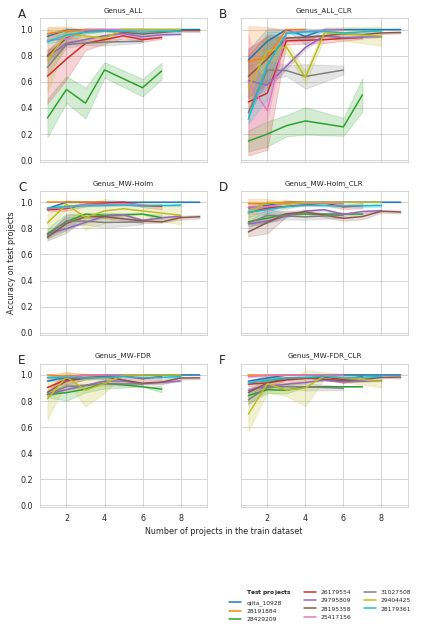

In [6]:
%%time
#comb_n = 2
comb_n = 200
sample_n = 5
total_pjc_res = pd.DataFrame()
levels = [5]
features = ['all','best_holm','best_fdr']
clr_b = [False,True]
sf = ['A','B','C','D','E','F']
sf_ind = 0
plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})
fig, axs = plt.subplots(3,2,figsize=(6.6,9),sharey=True,sharex=True)
i = 0
j = 0
for level,feature,clr_b in itertools.product(levels, features, clr_b):
    view_name = shared_functions.view_name(level,feature,clr_b)
    print(view_name)
    
    filename = shared_functions.make_name(level,feature,clr_b,False)
    rf = joblib.load('joblib/'+filename)   
    f,chao = bf[(level,feature)]
    tf = shared_functions.transformer(bf=f,chao=chao,level=level,clr_b=clr_b)
    r = pjc_curve(fixed_df=cd,project_df=humans,rf=rf,tf=tf,max_comb_n=comb_n,sample_n=sample_n)
    
    draw_pjc(r,view_name,axs[i][j])
    axs[i][j].annotate(sf[sf_ind],xy=(-0.13,1),xycoords='axes fraction',**{'size':12})

    r['name'] = view_name
    r['level'] = shared_functions.get_tax_name_by_level(level)
    r['features'] = feature
    r['CLR'] = clr_b
    total_pjc_res = pd.concat([total_pjc_res,r])
    
    sf_ind = sf_ind + 1
    j = j + 1
    if (j==axs.shape[1]):
        i = i + 1
        j = 0
handles, labels = axs[0][0].get_legend_handles_labels()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(b=None)
plt.ylabel('Accuracy on test projects')
plt.xlabel('Number of projects in the train dataset')
labels[0] = r'$\bf{Test \ projects}$'
plt.legend(handles, labels,loc = 'center left',bbox_to_anchor=(0.5, -0.2),frameon = False,ncol = 3)
plt.savefig('pics/SupplementaryFigure5.pdf', dpi = 300, bbox_inches='tight')

## Project curve averaged by test projects

In [ ]:
plt.rcParams.update({'font.size': 6,'axes.labelsize':8,'xtick.labelsize':8,'ytick.labelsize':8})
plt.figure(figsize=(3.32,3))
g = sns.lineplot(x="train_projects_n", y="accuracy",hue='features',style='CLR',
             ci=None, data=total_pjc_res)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
labels = [r'$\bf{RF \ features}$','all','MW-selected(Holm)','MW-selected(FDR)',
          r'$\bf{CLR}$','yes','no']
plt.legend(handles, labels,loc = 'lower right',ncol = 2)
plt.ylabel('Mean accuracy on test projects')
plt.xlabel('Number of projects in the train dataset')
plt.savefig('pics/Figure3.pdf', dpi = 300, bbox_inches='tight')

In [ ]:
x = joblib.dump(total_pjc_res,'joblib/catsNdogs_pjc.joblib')